In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.model_selection import train_test_split
import time
import matplotlib.pyplot as plt
from torchinfo import summary
import requests
import time
from torch.utils.data import Dataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Step 1: Download the dataset
url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
response = requests.get(url)
text = response.text  # This is the entire text data

# Step 2: Prepare the dataset
sequence_length = 20
# Create a character mapping to integers
chars = sorted(list(set(text)))
char_to_int = {ch: i for i, ch in enumerate(chars)}
int_to_char = {i: ch for i, ch in enumerate(chars)}

# Encode the text into integers
encoded_text = [char_to_int[ch] for ch in text]

# Create sequences and targets
sequences = []
targets = []
for i in range(0, len(encoded_text) - sequence_length):
    seq = encoded_text[i:i+sequence_length]
    target = encoded_text[i+sequence_length]
    sequences.append(seq)
    targets.append(target)

# Convert lists to PyTorch tensors
sequences = torch.tensor(sequences, dtype=torch.long)
targets = torch.tensor(targets, dtype=torch.long)

# Step 3: Create a dataset class
class CharDataset(Dataset):
    def __init__(self, sequences, targets):
        self.sequences = sequences
        self.targets = targets

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, index):
        return self.sequences[index], self.targets[index]

# Instantiate the dataset
dataset = CharDataset(sequences, targets)

# Step 4: Create data loaders
batch_size = 64
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(dataset=train_dataset, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size)

In [2]:
# Hyperparameters
hidden_size = 16
learning_rate = 0.001
num_layers = 3
nhead = 2
epochs = 10
length_dataset = len(chars)

# Defining the Transformer model
class CharTransformer(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, nhead):
        super(CharTransformer, self).__init__()
        self.embedding = nn.Embedding(input_size, hidden_size)
        encoder_layers = nn.TransformerEncoderLayer(hidden_size, nhead, dropout=0.2)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        embedded = self.embedding(x)
        transformer_output = self.transformer_encoder(embedded)
        output = self.fc(transformer_output[:, -1, :])  # Get the output of the last Transformer block
        return output
    
    # Hyperparameters

model = CharTransformer(length_dataset, hidden_size, length_dataset, num_layers, nhead).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)



In [3]:
def train(model, epochs, optimizer, criterion, train_loader, test_loader):
    train_losses = []
    val_accuracies = []
    start_time = time.time()
    initial_start_time = time.time()

    for epoch in range(1, epochs + 1):
        model.train()
        train_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
        train_loss = train_loss / len(train_loader.dataset)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        val_accuracy = correct / total
        val_accuracies.append(val_accuracy)

        end_time = time.time()
        print(f'Epoch [{epoch}/{epochs}], '
              f'Training Loss: {train_loss:.4f}, '
              f'Validation Accuracy: {val_accuracy*100:.2f}%'
              f', Time: {end_time - start_time:.2f}s')
        start_time = time.time()
    
    final_end_time = time.time()
    total_train_time = final_end_time - initial_start_time
    print("=======================================================================================================================")
    return train_losses, val_accuracies, total_train_time

In [42]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.model_selection import train_test_split
import time
import matplotlib.pyplot as plt
from torchinfo import summary
import requests
import time
from torch.utils.data import Dataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Step 1: Download the dataset
url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
response = requests.get(url)
text = response.text  # This is the entire text data

# Step 2: Prepare the dataset
sequence_length = 10
# Create a character mapping to integers
chars = sorted(list(set(text)))
char_to_int = {ch: i for i, ch in enumerate(chars)}
int_to_char = {i: ch for i, ch in enumerate(chars)}

# Encode the text into integers
encoded_text = [char_to_int[ch] for ch in text]

# Create sequences and targets
sequences = []
targets = []
for i in range(0, len(encoded_text) - sequence_length):
    seq = encoded_text[i:i+sequence_length]
    target = encoded_text[i+sequence_length]
    sequences.append(seq)
    targets.append(target)

# Convert lists to PyTorch tensors
sequences = torch.tensor(sequences, dtype=torch.long)
targets = torch.tensor(targets, dtype=torch.long)

# Step 3: Create a dataset class
class CharDataset(Dataset):
    def __init__(self, sequences, targets):
        self.sequences = sequences
        self.targets = targets

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, index):
        return self.sequences[index], self.targets[index]

# Instantiate the dataset
dataset = CharDataset(sequences, targets)

# Step 4: Create data loaders
batch_size = 64
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(dataset=train_dataset, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size)

# Hyperparameters
hidden_size = 16
learning_rate = 0.005
num_layers = 3
nhead = 4
epochs = 10
length_dataset = len(chars)

# Defining the Transformer model
class CharTransformer(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, nhead):
        super(CharTransformer, self).__init__()
        self.embedding = nn.Embedding(input_size, hidden_size)
        encoder_layers = nn.TransformerEncoderLayer(hidden_size, nhead, dropout=0.2)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        embedded = self.embedding(x)
        transformer_output = self.transformer_encoder(embedded)
        output = self.fc(transformer_output[:, -1, :])  # Get the output of the last Transformer block
        return output
    
    # Hyperparameters

model1 = CharTransformer(length_dataset, hidden_size, length_dataset, num_layers, nhead).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model1.parameters(), lr=learning_rate)




def train(model, epochs, optimizer, criterion, train_loader, test_loader):
    train_losses = []
    val_accuracies = []
    start_time = time.time()
    initial_start_time = time.time()

    for epoch in range(1, epochs + 1):
        model.train()
        train_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
        train_loss = train_loss / len(train_loader.dataset)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        val_accuracy = correct / total
        val_accuracies.append(val_accuracy)

        end_time = time.time()
        print(f'Epoch [{epoch}/{epochs}], '
              f'Training Loss: {train_loss:.4f}, '
              f'Validation Accuracy: {val_accuracy*100:.2f}%'
              f', Time: {end_time - start_time:.2f}s')
        start_time = time.time()
    
    final_end_time = time.time()
    total_train_time = final_end_time - initial_start_time
    print("=======================================================================================================================")
    return train_losses, val_accuracies, total_train_time





train_loss1, val_acc1, time1 = train(model1, epochs, optimizer, criterion, train_loader, test_loader)

Epoch [1/10], Training Loss: 2.6815, Validation Accuracy: 25.91%, Time: 112.86s
Epoch [2/10], Training Loss: 2.6066, Validation Accuracy: 26.38%, Time: 115.14s
Epoch [3/10], Training Loss: 2.5872, Validation Accuracy: 26.51%, Time: 111.50s
Epoch [4/10], Training Loss: 2.5778, Validation Accuracy: 26.66%, Time: 111.88s
Epoch [5/10], Training Loss: 2.5714, Validation Accuracy: 26.79%, Time: 110.15s
Epoch [6/10], Training Loss: 2.5675, Validation Accuracy: 26.78%, Time: 109.64s
Epoch [7/10], Training Loss: 2.5644, Validation Accuracy: 26.65%, Time: 109.59s
Epoch [8/10], Training Loss: 2.5614, Validation Accuracy: 26.86%, Time: 109.23s
Epoch [9/10], Training Loss: 2.5612, Validation Accuracy: 26.75%, Time: 109.10s
Epoch [10/10], Training Loss: 2.5592, Validation Accuracy: 26.71%, Time: 110.57s


In [4]:
train_loss, val_acc, time = train(model, epochs, optimizer, criterion, train_loader, test_loader)

Epoch [1/10], Training Loss: 2.6040, Validation Accuracy: 26.71%, Time: 105.31s
Epoch [2/10], Training Loss: 2.5325, Validation Accuracy: 26.58%, Time: 105.00s
Epoch [3/10], Training Loss: 2.5201, Validation Accuracy: 26.75%, Time: 105.32s
Epoch [4/10], Training Loss: 2.5130, Validation Accuracy: 26.94%, Time: 107.72s
Epoch [5/10], Training Loss: 2.5083, Validation Accuracy: 26.75%, Time: 107.59s
Epoch [6/10], Training Loss: 2.5037, Validation Accuracy: 26.99%, Time: 105.95s
Epoch [7/10], Training Loss: 2.4996, Validation Accuracy: 26.87%, Time: 105.67s
Epoch [8/10], Training Loss: 2.4962, Validation Accuracy: 26.92%, Time: 105.92s
Epoch [9/10], Training Loss: 2.4921, Validation Accuracy: 26.73%, Time: 105.66s
Epoch [10/10], Training Loss: 2.4888, Validation Accuracy: 26.90%, Time: 105.62s


In [40]:
train_loss = [2.6040, 2.5325, 2.5201, 2.5130, 2.5083, 2.5037, 2.4996, 2.4962, 2.4921, 2.4888]
val_acc = [0.2671, 0.2658, 0.2675, 0.2694, 0.2675, 0.2699, 0.2687, 0.2692, 0.2673, 0.2690] 

print(val_acc)
time = [117.56, 110.27, 109.92, 110.13, 111.25, 112.68, 112.17, 115.75, 112.47, 112.62]

time1 = [122.81, 128.49, 128.08, 128.23, 129.64, 127.06, 124.02, 116.61, 112.77, 118.60]
total = 0.0
for i in range(len(time1)):
    total += time1[i]

print(total)
avg = total/(len(time))
print(avg/60)

[0.2671, 0.2658, 0.2675, 0.2694, 0.2675, 0.2699, 0.2687, 0.2692, 0.2673, 0.269]
20.605166666666666
2.0605166666666666


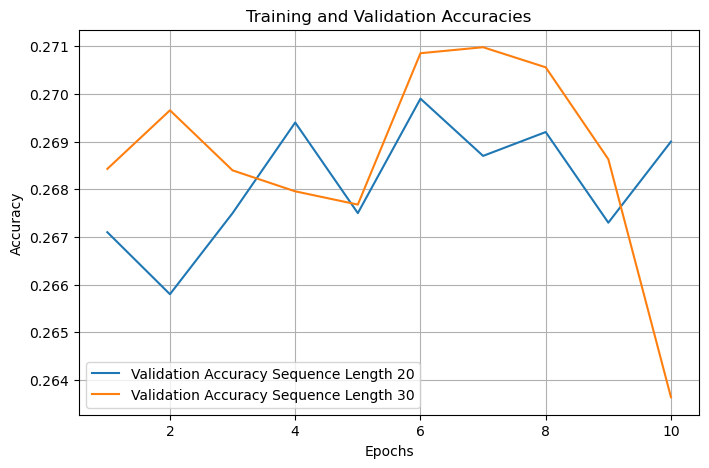

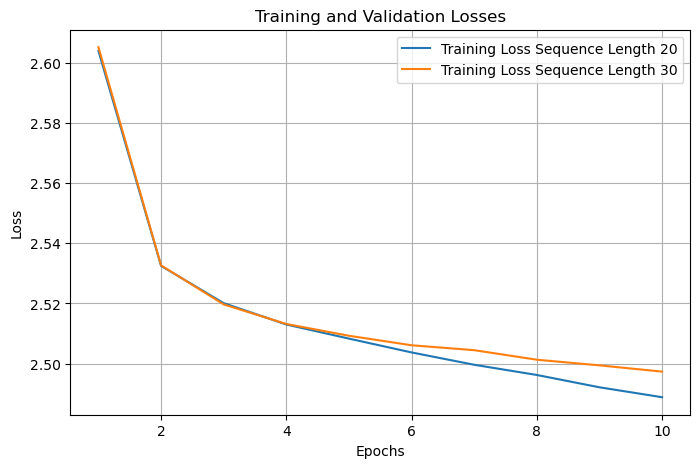

In [32]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, epochs+1), val_acc, label='Validation Accuracy Sequence Length 20')
plt.plot(range(1, epochs+1), val_acc1, label='Validation Accuracy Sequence Length 30')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracies')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(range(1, epochs+1), train_loss, label='Training Loss Sequence Length 20')
plt.plot(range(1, epochs+1), train_loss1, label='Training Loss Sequence Length 30')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.grid(True)
plt.show()


In [33]:
import torchinfo

hidden_size = 16
learning_rate = 0.001
num_layers = 3
nhead = 2
epochs = 10
length_dataset = len(chars)

model2 = CharTransformer(length_dataset, hidden_size, length_dataset, num_layers, nhead)
summary(model2)

Layer (type:depth-idx)                                            Param #
CharTransformer                                                   --
├─Embedding: 1-1                                                  1,040
├─TransformerEncoder: 1-2                                         --
│    └─ModuleList: 2-1                                            --
│    │    └─TransformerEncoderLayer: 3-1                          68,752
│    │    └─TransformerEncoderLayer: 3-2                          68,752
│    │    └─TransformerEncoderLayer: 3-3                          68,752
├─Linear: 1-3                                                     1,105
Total params: 208,401
Trainable params: 208,401
Non-trainable params: 0